In [1]:
create_tokenizedDF= False
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
from collections import Counter
import nltk
from numpy import trapz
from scipy.signal import find_peaks

stop_words_nltk = nltk.corpus.stopwords.words('portuguese')
snowball = nltk.stem.snowball.SnowballStemmer('portuguese')
right=[ 'PSD',  'CDS-PP', 'CH','IL','CDS']
left=[ 'PS', 'BE', 'PCP', 'PAN', 'PEV','L']

In [2]:
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)
         
    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

def create_tokenized_dataset(df_input):
    # 1 create token column: tokens
    df_input['tokens']=df_input['speech'].apply(lambda x: nltk.word_tokenize(x))
    # 2 create token without stopwords and stemmer: tokens_stemer_stop. 16min
    df_input['tokens_stemer_stop'] = df_input['tokens'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))
    
    # 3 extract very frequent or rare words: token_cleaned
    flat_tokens=[item for sublist in df_input['tokens_stemer_stop'] for item in sublist]
    aux_c=Counter(flat_tokens)
        
    extrat_common=['par', 'nao', 'sr', 'deput', 'govern', 'muit', 'pel', 'president','tod','tamb','srs','sras','pod','part','psd','sao','aplaus','ja','porqu','faz','ha','diz','quer','pais','sobr','bem','nest']
    extract_rare=[x[0] for x in aux_c.most_common()[-30:]]

    df_input['tokens_cleaned'] = df_input['tokens_stemer_stop'].apply(lambda x : [i for i in x if not i in extrat_common])
    df_input['tokens_cleaned'] = df_input['tokens_cleaned'].apply(lambda x : [i for i in x if not i in extract_rare])
    df_input.to_pickle('dftok.pkl')  
    return df_input

def generate_N_grams(text,ngram=1):
  words=[word for word in text]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

def create_grams(df_frame, n):
    grams_d={1: 'uni_grams', 2: 'bi_grams', 3: 'tri_grams'}
    df_frame[grams_d[n]] = df_frame['tokens_cleaned'].apply(lambda x: generate_N_grams(x,n))
    return df_frame 

#political polarization functions




def create_frequency_table_grams(n_gram=1, indf=None, right_parties=right, left_parties=left):
    grams_d={1: 'uni_grams', 2: 'bi_grams', 3: 'tri_grams'}
   

    r_grams=[item for sublist in indf[indf.party.isin(right)][grams_d[n_gram]] for item in sublist]
    l_grams=[item for sublist in indf[indf.party.isin(left)][grams_d[n_gram]] for item in sublist]

    total_counter = Counter([item for sublist in indf[grams_d[n_gram]] for item in sublist])
    right_counter = Counter(r_grams)
    left_counter = Counter(l_grams)

    df_all = pd.DataFrame.from_dict(total_counter, orient='index').reset_index()
    df_all.columns=['phrase','count']
    df_all['count_right']=[right_counter[x] for x in df_all.phrase]
    df_all['count_left']=[left_counter[x] for x in df_all.phrase]


    df_all['count_left_total']=sum(left_counter.values())
    df_all['count_right_total']=sum(right_counter.values())
    # frequency of every words except the given one (by row)
    #Jensen et al. (2012),p.10 
    #f-pck is the frequency of all phrases used in Con­gress c by party k excluding phrase p
    df_all['f_right_minus']=( df_all['count_right_total']-df_all['count_right'])/df_all['count_right_total']
    df_all['f_left_minus']=( df_all['count_left_total']-df_all['count_left'])/df_all['count_left_total']

    df_all['f_right']=df_all['count_right']/df_all['count_right_total']
    df_all['f_right_norm'] = (df_all['f_right'] - df_all['f_right'].min()) / (df_all['f_right'].max() - df_all['f_right'].min())  
    df_all['f_left']=df_all['count_left']/df_all['count_left_total']
    df_all['f_left_norm'] = (df_all['f_left'] - df_all['f_left'].min()) / (df_all['f_left'].max() - df_all['f_left'].min())  

    df_all['f_right_minus_norm']=(df_all['f_right_minus'] - df_all['f_right_minus'].min()) / (df_all['f_right_minus'].max() - df_all['f_right_minus'].min()) 
    df_all['f_left_minus_norm']=(df_all['f_left_minus'] - df_all['f_left_minus'].min()) / (df_all['f_left_minus'].max() - df_all['f_left_minus'].min()) 

    return df_all


def calculate_pearson(df_all):
    aa=df_all['f_right_norm']*df_all['f_left_minus_norm'] 
    bb=df_all['f_left_norm']*df_all['f_right_minus_norm']
    cc=aa-bb
    dd=cc*cc
    d11=df_all['f_right_norm']+df_all['f_left_norm']
    d22=df_all['f_right_norm']+df_all['f_right_minus_norm']
    d33=df_all['f_left_norm']+df_all['f_left_minus_norm']
    d44=df_all['f_right_minus_norm']+df_all['f_left_minus_norm']
    denom=d11*d22*d33*d44
    pp=dd/denom
    return pp

def create_phrase_partisanship(df):
    aa=df['f_right_norm']+df['f_left_norm']
    df['rho']=df['f_right_norm']/aa
    
    df['gram_partisanship']= 0.5 * df['f_right_norm']*df['rho']+0.5 *df['f_right_norm']*(1-df['rho'])
    
    return df

def create_polarization_correlation(df):
    
    aa=df['f_left_norm']*-1
    bb= df['f_right_norm']*1
    df['beta_polarization']=aa+bb

    return df

def partisanship_by_speach(df_in,partisan_dict, new_column='partisanship', ngrams_col='tri_grams'):
    df_in[new_column] = [np.empty(0,dtype=float)]*len(df_in)
    df_in[new_column] =df_in[new_column].astype(object)
    out_res=[]
    for n,row in enumerate(df_in[ngrams_col]):
    
        res=[]
        for x in row:
            
            if x in partisan_dict:
                res.append( partisan_dict[x])
            
            else:
                res.append( 0)
        out_res.append(res)
    df_in[new_column]=out_res
    return df_in

def create_200r(df_mainf):
    indexes_no_applause=[n for n,x in enumerate(df_mainf.phrase) if 'aplausos' not in x]
    df_mainf=df_mainf.iloc[indexes_no_applause]

    tri_final = df_mainf[0:200].append(df_mainf[-200:], ignore_index=True)
    return tri_final


def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return  idx

In [3]:
# load dataframe
if create_tokenizedDF==True:
    df_input = pd.read_pickle('parliament_fdf.pkl')  
    df_tok=create_tokenized_dataset(df_input)
else:
    df_tok = pd.read_pickle('dftok.pkl')  
    

In [4]:
# 1 Create n-grams
#df_tok=create_grams(df_tok, 2)
df_tok=create_grams(df_tok, 3)

In [5]:
# 2 create frequency table
df_freq=create_frequency_table_grams(n_gram=3, indf=df_tok, right_parties=right, left_parties=left)
# 3 Filter pearson >0
df_freq['pearson_quad']=calculate_pearson(df_freq)
trigrams_table=df_freq[df_freq.pearson_quad>0]
#  4 Add  partisanship by word
trigrams_table=create_phrase_partisanship(trigrams_table)
trigrams_table=create_polarization_correlation(trigrams_table)
trigrams_table=trigrams_table.sort_values(by='gram_partisanship',ascending=False)


In [6]:
# 5 Dictionary of trigrams and partisanship
partisan_dict=dict(zip(trigrams_table.phrase,trigrams_table.gram_partisanship))

In [7]:
# 6 Partisanship by speach
df_tok=partisanship_by_speach(df_in=df_tok, new_column='partisanship', ngrams_col='tri_grams',partisan_dict=partisan_dict)
df_tok['avg_partisanship']=df_tok.partisanship.apply(lambda x: sum(x))

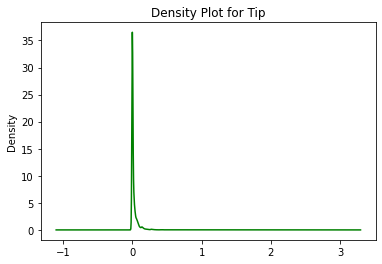

In [8]:
df_tok.head(5)
import seaborn as sns
import matplotlib.pyplot as plt
df_tok['avg_partisanship'].plot.density(color='green')
plt.title('Density Plot for Tip')
plt.show()


C:\Users\trind\AppData\Local\Temp\ipykernel_6988\793341432.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tri_final = df_tok[0:200].append(df_tok[-200:], ignore_index=True)


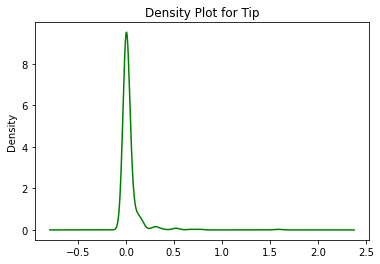

In [9]:
tri_final = df_tok[0:200].append(df_tok[-200:], ignore_index=True)
tri_final['avg_partisanship'].plot.density(color='green')
plt.title('Density Plot for Tip')
plt.show()

In [10]:
df_tok.sort_values("avg_partisanship", axis =0, ascending = False,inplace = True)
tri_final = df_tok[0:200].append(df_tok[-200:], ignore_index=True)

C:\Users\trind\AppData\Local\Temp\ipykernel_6988\3479927013.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tri_final = df_tok[0:200].append(df_tok[-200:], ignore_index=True)


In [48]:
df_tok.head(1)

,speaker,speech,filename,number,session,term,Date,link,party,speaker_ntime,genre,len_speech,year,tokens,tokens_stemer_stop,tokens_cleaned,tri_grams,partisanship,avg_partisanship
40987,joaopaulocorreia,sr presidente sr primeiroministro dirijo uma p...,darl13sl03n073.txt,73,3,13,2018-04-18,https://debates.parlamento.pt/catalogo/r3/dar/...,PS,885.0,M,1412,2018,"[sr, presidente, sr, primeiroministro, dirijo,...","[sr, president, sr, primeiroministr, dirij, pr...","[primeiroministr, dirij, primeir, palavr, saud...","[primeiroministr dirij primeir, dirij primeir ...","[0.0, 0.0006456611570247934, 0.001033057851239...",2.195506


In [49]:
#unique speakers, keeping the last year they spoke
min_speaker=df_tok[['speaker','party','term', 'year']].groupby('speaker', group_keys=False).apply(lambda x: x.loc[x['year'].idxmin()])

min_speaker.columns=['speaker1','party', 'term', 'year']
min_speaker=min_speaker.reset_index()
min_speaker.drop('speaker1', axis=1,inplace=True)
min_speaker.columns=['speaker', 'party1','term_ini', 'year_ini']

max_speaker=df_tok[['speaker','party','term', 'year']].groupby('speaker', group_keys=False).apply(lambda x: x.loc[x['year'].idxmax()])

max_speaker.columns=['speaker1', 'party','term', 'year']
max_speaker=max_speaker.reset_index()
max_speaker.drop('speaker1', axis=1,inplace=True)
max_speaker.columns=['speaker','party', 'term_max', 'year_max']

In [52]:
deputies_speak=min_speaker.merge(max_speaker, how='left', on='speaker')
deputies_speak.drop('party1', axis=1,inplace=True)
deputies_speak.to_pickle('deputies_for _twitter.pkl')

In [53]:
deputies_speak

,speaker,term_ini,year_ini,party,term_max,year_max
0,abelbaptista,13,2015,CDS-PP,13,2016
1,adaosilva,13,2015,PSD,14,2021
2,afonsooliveira,14,2019,PSD,14,2021
3,albertofonseca,14,2019,PSD,14,2021
4,albertomachado,14,2019,PSD,14,2021
...,...,...,...,...,...,...
348,ulissespereira,13,2016,PSD,13,2019
349,vaniadiasdasilva,13,2015,CDS-PP,14,2021
350,verabraz,13,2015,CDS-PP,14,2021
351,vitalinocanas,13,2015,PS,13,2019


In [16]:
tri_final.head()

,speaker,speech,filename,number,session,term,Date,link,party,speaker_ntime,genre,len_speech,year,tokens,tokens_stemer_stop,tokens_cleaned,tri_grams,partisanship,avg_partisanship
0,joaopaulocorreia,sr presidente sr primeiroministro dirijo uma p...,darl13sl03n073.txt,73,3,13,2018-04-18,https://debates.parlamento.pt/catalogo/r3/dar/...,PS,885.0,M,1412,2018,"[sr, presidente, sr, primeiroministro, dirijo,...","[sr, president, sr, primeiroministr, dirij, pr...","[primeiroministr, dirij, primeir, palavr, saud...","[primeiroministr dirij primeir, dirij primeir ...","[0.0, 0.0006456611570247934, 0.001033057851239...",2.195506
1,moisesferreira,sr presidente sras e srs deputados o servico n...,darl13sl03n058.txt,58,3,13,2018-03-09,https://debates.parlamento.pt/catalogo/r3/dar/...,BE,853.0,M,534,2018,"[sr, presidente, sras, e, srs, deputados, o, s...","[sr, president, sras, srs, deput, servic, naci...","[servic, nacional, saud, duv, maior, conquist,...","[servic nacional saud, nacional saud duv, saud...","[0.13326446280991738, 0.00012913223140495868, ...",1.946798
2,moisesferreira,sr presidente comeco por cumprimentar o sr dep...,darl13sl02n034.txt,34,2,13,2017-01-05,https://debates.parlamento.pt/catalogo/r3/dar/...,BE,853.0,M,503,2017,"[sr, presidente, comeco, por, cumprimentar, o,...","[sr, president, comec, cumpriment, sr, deput, ...","[comec, cumpriment, joa, ram, sra, luis, salgu...","[comec cumpriment joa, cumpriment joa ram, joa...","[0.0005165289256198347, 0.0, 0.0, 0.0, 0.00142...",1.913352
3,moisesferreira,sr presidente sras e srs deputados hoje ningue...,darl14sl02n046.txt,46,2,14,2021-02-18,https://debates.parlamento.pt/catalogo/r3/dar/...,BE,853.0,M,662,2021,"[sr, presidente, sras, e, srs, deputados, hoje...","[sr, president, sras, srs, deput, hoj, ningu, ...","[hoj, ningu, capaz, coloc, caus, importanc, pa...","[hoj ningu capaz, ningu capaz coloc, capaz col...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001291322314...",1.911157
4,heloisaapolonia,sr presidente srs membros do governo sras e sr...,darl13sl03n103.txt,103,3,13,2018-07-05,https://debates.parlamento.pt/catalogo/r3/dar/...,PEV,1492.0,F,835,2018,"[sr, presidente, srs, membros, do, governo, sr...","[sr, president, srs, membr, govern, sras, srs,...","[membr, verd, consid, imper, defes, servic, na...","[membr verd consid, verd consid imper, consid ...","[0.0, 0.0, 0.0, 0.0, 0.00025826446280991736, 0...",1.849819


In [12]:
YEAR_S=2018

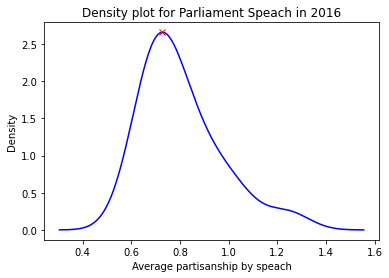

0.7963331523460946 0


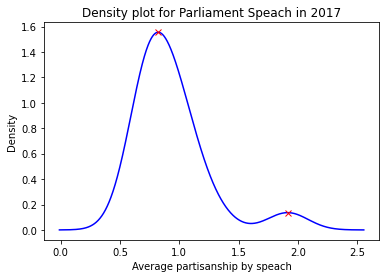

1o 0.9161423936431703 0.08323060708580497


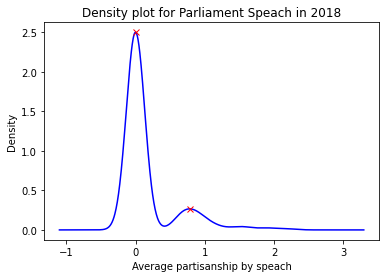

1o 0.8327208556144106 0.13042573273557104


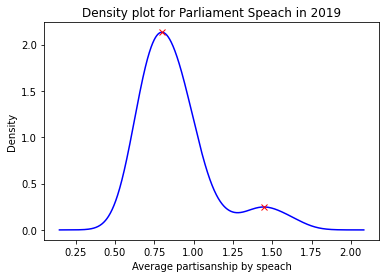

1o 0.869321273013123 0.12793056049954568


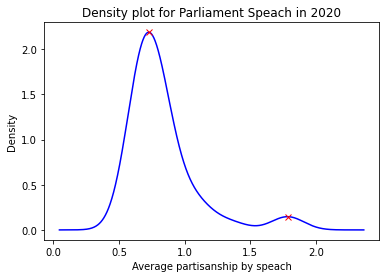

1o 0.9257688615171447 0.07379755290802323


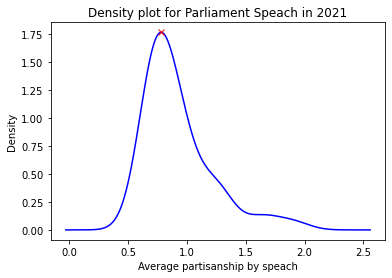

0.8288794356376555 0


<Figure size 432x288 with 0 Axes>

In [19]:
# 
df_polmetric=pd.DataFrame([])

for YEAR_S in range(2016, 2022):
    res=[]
    tri_final[tri_final.year==YEAR_S]['avg_partisanship'].plot.density(color='blue')
    plt.title('Density plot for Parliament Speach in '+ str(YEAR_S))
    plt.xlabel('Average partisanship by speach')
    line = plt.gca().get_lines()
    x_data = line[0].get_data()[0]
    y1_data = line[0].get_data()[1]
    peaks, _ = find_peaks(y1_data, height=0)
    plt.plot(x_data[peaks[0]],y1_data[peaks[0]], "x", color='red')
    if len(peaks)>1:
        plt.plot(x_data[peaks[1]],y1_data[peaks[1]], "x", color='red')

    plt.show()
    plt.clf()
    if len(peaks)>1:
        #distance_from_peaks=x_data[peaks[0]]

        first_peak_startX=x_data[0]
        fstartY=find_nearest_idx(x_data, first_peak_startX)
        #print(fstartY,fendY)
        first_peak_endX=x_data[peaks[0]]+((x_data[peaks[1]]-x_data[peaks[0]])/2 )
        fendY=find_nearest_idx(x_data, first_peak_endX)
        area_left = trapz(y1_data[fstartY:fendY], x_data[fstartY:fendY],dx=1)

        second_peak_start=first_peak_endX
        SstartY=find_nearest_idx(x_data, second_peak_start)
        second_peak_end=x_data[peaks[1]]+((x_data[peaks[1]]-x_data[peaks[0]])/2 )
        SendY=find_nearest_idx(x_data, second_peak_end)


        area_right = trapz(y1_data[SstartY:SendY], x_data[SstartY:SendY],dx=1)

        print('1o', area_left,area_right)
    else:
        distance_from_peaks=min(x_data[:peaks[0]])

        first_peak_startX=x_data[0]
        fstartY=find_nearest_idx(x_data, first_peak_startX)

        first_peak_endX=x_data[peaks[0]]+((x_data[peaks[0]]-x_data[0])/2 )
        fendY=find_nearest_idx(x_data, first_peak_endX)
        area_left = trapz(y1_data[fstartY:fendY], x_data[fstartY:fendY],dx=1)

        area_right=0
        print(area_left,area_right)

    res.append(YEAR_S)
    if len(peaks)>1:
        res.append(x_data[peaks[1]]-x_data[peaks[0]]) #partisanship_interval
    else:
        res.append(0)
    res.append(area_left)
    res.append( area_right)

    new_df = pd.DataFrame([res])
    df_polmetric = pd.concat([df_polmetric, new_df], axis=0, ignore_index=True)
    

In [20]:
df_polmetric.columns='year','partisanship_interval', 'left_probability','right_probability'
df_polmetric

,year,partisanship_interval,left_probability,right_probability
0,2016,0.000000,0.796333,0.000000
1,2017,1.091581,0.916142,0.083231
2,2018,0.777987,0.832721,0.130426
3,2019,0.648760,0.869321,0.127931
4,2020,1.058149,0.925769,0.073798
5,2021,0.000000,0.828879,0.000000


In [15]:
#graficos tabela
#graficos porlegislatura

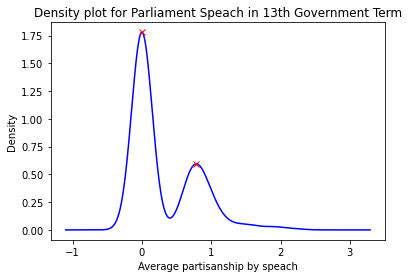

1o 0.6625625595853576 0.28836807060543246


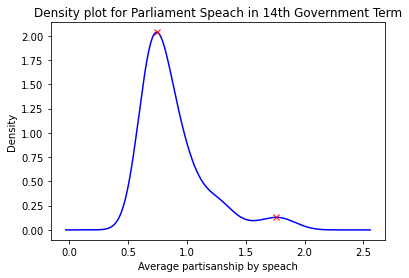

1o 0.8913989981527368 0.10769083202487115


<Figure size 432x288 with 0 Axes>

In [22]:
# 
df_polmetric=pd.DataFrame([])

for YEAR_S in range(13, 15):
    res=[]
    tri_final[tri_final.term==YEAR_S]['avg_partisanship'].plot.density(color='blue')
    plt.title('Density plot for Parliament Speach in '+ str(YEAR_S)+ 'th Government Term')
    plt.xlabel('Average partisanship by speach')
    line = plt.gca().get_lines()
    x_data = line[0].get_data()[0]
    y1_data = line[0].get_data()[1]
    peaks, _ = find_peaks(y1_data, height=0)
    plt.plot(x_data[peaks[0]],y1_data[peaks[0]], "x", color='red')
    if len(peaks)>1:
        plt.plot(x_data[peaks[1]],y1_data[peaks[1]], "x", color='red')

    plt.show()
    plt.clf()
    if len(peaks)>1:
        #distance_from_peaks=x_data[peaks[0]]

        first_peak_startX=x_data[0]
        fstartY=find_nearest_idx(x_data, first_peak_startX)
        #print(fstartY,fendY)
        first_peak_endX=x_data[peaks[0]]+((x_data[peaks[1]]-x_data[peaks[0]])/2 )
        fendY=find_nearest_idx(x_data, first_peak_endX)
        area_left = trapz(y1_data[fstartY:fendY], x_data[fstartY:fendY],dx=1)

        second_peak_start=first_peak_endX
        SstartY=find_nearest_idx(x_data, second_peak_start)
        second_peak_end=x_data[peaks[1]]+((x_data[peaks[1]]-x_data[peaks[0]])/2 )
        SendY=find_nearest_idx(x_data, second_peak_end)


        area_right = trapz(y1_data[SstartY:SendY], x_data[SstartY:SendY],dx=1)

        print('1o', area_left,area_right)
    else:
        distance_from_peaks=min(x_data[:peaks[0]])

        first_peak_startX=x_data[0]
        fstartY=find_nearest_idx(x_data, first_peak_startX)

        first_peak_endX=x_data[peaks[0]]+((x_data[peaks[0]]-x_data[0])/2 )
        fendY=find_nearest_idx(x_data, first_peak_endX)
        area_left = trapz(y1_data[fstartY:fendY], x_data[fstartY:fendY],dx=1)

        area_right=0
        print(area_left,area_right)

    res.append(YEAR_S)
    if len(peaks)>1:
        res.append(x_data[peaks[1]]-x_data[peaks[0]]) #partisanship_interval
    else:
        res.append(0)
    res.append(area_left)
    res.append( area_right)

    new_df = pd.DataFrame([res])
    df_polmetric = pd.concat([df_polmetric, new_df], axis=0, ignore_index=True)

In [23]:
df_polmetric.columns='term','partisanship_interval', 'left_probability','right_probability'
df_polmetric

,term,partisanship_interval,left_probability,right_probability
0,13,0.786778,0.662563,0.288368
1,14,1.017621,0.891399,0.107691
